<a href="https://colab.research.google.com/github/amangup/random_excursions/blob/master/rating_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Monte Carlo simulations for voting systems to rank a leaderboard

The movie Social Network made popular a rating system, used in Mark Zuckerberg's website Facemash, which can create a ranking of participants by making users choose one from a pair of faces shown to them. This rating system was originally designed for [chess tournaments](https://en.wikipedia.org/wiki/Chess_rating_system) - to rate players using the results of chess games.

I want to simulate a slightly simplified version and see what factors affect the outcome of such a voting system. The situation is
- There are a fixed number of players
- Each player is also a voter who is presented a number of choices to choose from (e.g. 2 faces in Facemash) - and making one choice counts as one vote. Each player may be asked to vote multiple times.
- Each player starts with the same score. Each vote adjusts the scores of the players presented in that vote - the score of the winner increases, and the score for others decreases. The sum of all scores remains constant.

### Assumptions
To design a simulation we need to make some assumptions

- We assume that each player has an _innate_ quality score.
- In simulating the voting choice of each voter, the choice with the **highest innate quality score** is most likely to be chosen.

### Error metric
The innate quality metric is normalized to [0, 1]. We normalize the final score (the outcome of voting) to [0,1] as well, and then calculate RMSE as error.

### Situations we want to look at
- If each voter is asked to vote more times, does the accuracy improve?
- If each voter is given more than 2 choices in each vote, does that help?
- What happens if we assume different distribution of innate quality of the players?


**You can skip to the Results section if you are not interested in the code for the simulation**






In [0]:
import matplotlib.pyplot as plt
import numpy as np
from math import exp
from random import random, sample


Our simulation is designed as follows:

- We start with score = 1 for each player
- Each player rates `n_games` games. We would expect as players vote more times, the accuracy of outcome will improve
- A number of players can be malicious, i.e., they knowingly vote for the bad teams instead of good ones. `mal_prob` indicates the probability a player is malicious.
- The _innate_ quality score of a player is defined by the `quality_f` (in the range [0, 1]). If this function is linear, that means teams cover the spectrum of ability uniformly. If it has an asymptote at 1, that means there are a lot of high quality teams. And so on.
- Given a number of teams to vote among, `rating_f()` defines the logic by which the voter will make that choice. It is assumed that every voter uses the same logic, but since that logic is randomized the actual votes for each player will be different.
- `gameset_f()` creates a set of games for each voter. These are choices presented to each user in each vote. Note that this can be greater than 2, i.e., voter can be asked to choose the best among 4 choices, for example.

Given these inputs:
- we create voting instances (aka games) for all players, and simulate their choice.
- For each game, we increase the score of the winner, and decrease the score of non-winners (s.t. it remains a zero sum game).
- We normalize the final score array to [0, 1], and calculate the RMSE between the score resulting from the vote and the innate quality scores that we started with.

In [0]:
def ranking_error(num_players, n_games, delta, mal_prob, choices_per_game, quality_f, rating_f, gameset_f):
    score = [1] * num_players

    for _ in range(num_players):
        game_set = gameset_f(num_players, n_games, choices_per_game)
        malicious = random() < mal_prob
        
        
        for competition in game_set:
            ratings = rating_f(competition, num_players, quality_f, malicious)
            for pl_index in range(len(competition)):
                score[competition[pl_index]] += ratings[pl_index] * delta

    max_min = max(score) - min(score)
    c_term = min(score) / max_min
    score_norm = [(value/max_min) - c_term for value in score]

    original_score = [quality_f(i, num_players) for i in range(num_players)]
    sse = sum([(a - e) ** 2 for (a, e) in zip(original_score, score_norm)])
    rmse = (sse / num_players) ** 0.5
    return rmse

The `rate()` function below decides who wins among a number of players. 
- every player is given a winning probability proportional to their innate quality
- we select a winner using that probabilities as the distribution over all players. In case `malicious=True`, we use `1-pdf` instead of the standard `pdf` to choose winner.
- The sum of return value `ratings` is 0, so the games remains 0 sum at all times.

In [0]:
def _logistic_(x):
    return 1/(1 + exp(-10 * (x-0.5)))


def rate(players, num_players, quality_f, malicious=False):
    quality_scores = [quality_f(player, num_players) for player in players]
    
    sum_quality = sum(quality_scores)    
    probs = [_logistic_(score/sum_quality) for score in quality_scores]
    
    sum_probs = sum(probs)
    probs_norm = [x/sum_probs for x in probs]
    
    if malicious:
      probs_norm = [1-p for p in probs_norm]
      
    winner = np.random.choice(players, 1, p=probs_norm)

    ratings = [-1/(num_players-1)] * len(players)

    ratings[players.index(winner)] = 1

    return ratings


The `select_games()` creates the sets of teams among which the voter will have to choose. 
- It creates `n_games` sets, i.e., each voter votes `n_games` times. Each set has `choices_per_game` teams as competitors.

In [0]:
def select_games(num_players, n_games, choices_per_game=2):
    games = set()
    players = range(num_players)
    while len(games) < n_games:
        game = sample(players, choices_per_game)
        games.add(tuple(game))

    return games

Finally we define a function which executes multiple trials and averages the error.

In [0]:
def get_avg_error(trials, n_games, mal_prob, choices_per_game, quality_f):
    error = 0
    for i in range(trials):
        error += ranking_error(100, n_games, delta=0.02, mal_prob=mal_prob, 
                               choices_per_game=choices_per_game, 
                               quality_f=quality_f, rating_f=rate, 
                               gameset_f=select_games)

    return error/trials

## Results

Let's start with a quality function that is linear. This means that players of all quality are uniformly distributed.

In [0]:
def quality1(user_id, num_users):
    return user_id/num_users

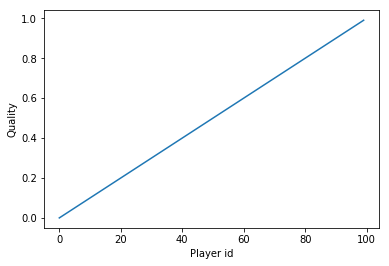

In [53]:
plt.plot(range(100), [quality1(i, 100) for i in range(100)])
plt.ylabel("Quality")
plt.xlabel("Player id")
plt.show()

### Situation 1
As our first experiment, let's see if our voting system works better if increase the number of comparisons each voter votes for. We are going to plot error against the number of votes per voter.

As you can see in the graph, **more votes per voter give us more information, and error goes down as a result**.

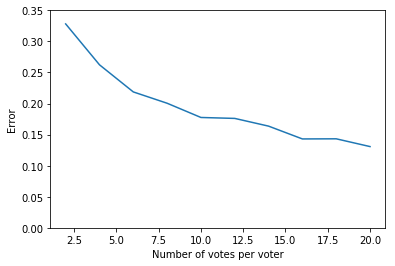

In [30]:
num_votes_error = []
for i in range(2, 21, 2):
    num_votes_error.append(get_avg_error(10, n_games=i, mal_prob=0, 
                                         choices_per_game=2, quality_f=quality1))
    
plt.plot(range(2, 21, 2), num_votes_error)
plt.ylim((0, 0.35))
plt.ylabel("Error")
plt.xlabel("Number of votes per voter")
plt.show()

### Situation 2

In this case, we see if instead of giving voters a choice of 2 players, we give them a choice of 3 or more players at one time.

According to the simulation, **more choices per vote doesn't reduce the error**. Thus, it's good to stick with only 2 choices at a time.

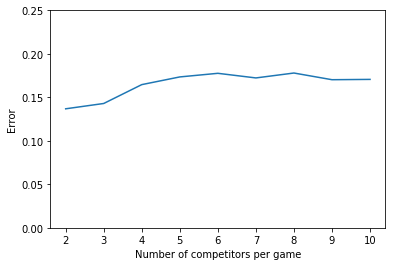

In [29]:
game_size_error = []
for i in range(2, 11):
    game_size_error.append(get_avg_error(10, n_games=20, mal_prob=0,
                                         choices_per_game=i, quality_f=quality1))
    
plt.plot(range(2, 11), game_size_error)
plt.ylim((0, 0.25))
plt.ylabel("Error")
plt.xlabel("Number of competitors per game")
plt.show()

### Situation 3

Let's change the quality function so that there are more players who are extremely good, and very few players that are really bad.

In [0]:
def quality2(user_id, num_users):
    return (user_id/num_users)**0.2

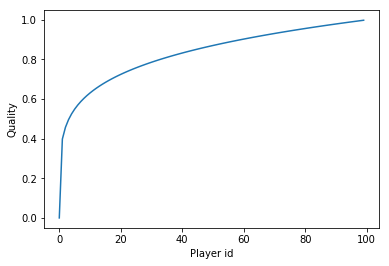

In [55]:
plt.plot(range(100), [quality2(i, 100) for i in range(100)])
plt.ylabel("Quality")
plt.xlabel("Player id")
plt.show()

It's clear that the error for this new quality distribution, **the error is much higher than our previous quality function.**

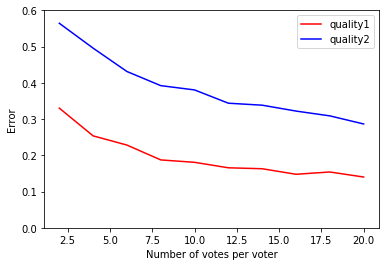

In [41]:
num_votes_error1 = []
num_votes_error2 = []
for i in range(2, 21, 2):
    num_votes_error1.append(get_avg_error(10, n_games=i, mal_prob=0, 
                                          choices_per_game=2, quality_f=quality1))
    num_votes_error2.append(get_avg_error(10, n_games=i, mal_prob=0, 
                                          choices_per_game=2, quality_f=quality2))

    
plt.plot(range(2, 21, 2), num_votes_error1, color='red', label='quality1')
plt.plot(range(2, 21, 2), num_votes_error2, color='blue', label='quality2')
plt.ylim((0, 0.6))
plt.ylabel("Error")
plt.xlabel("Number of votes per voter")
plt.legend(loc='upper right')
plt.show()

### Situation 4

This is the reverse of Situation 3, i.e., a lot of players are bad and a few players are very good. In an open tournament, this distribution is likely to be close to the actual distribution.

In [0]:
def quality3(user_id, num_users):
    return (user_id/num_users)**4

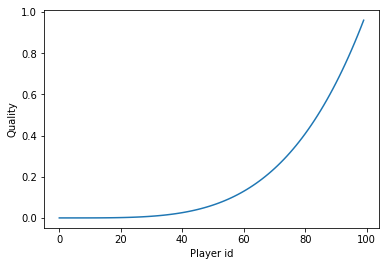

In [45]:
plt.plot(range(100), [quality3(i, 100) for i in range(100)])
plt.ylabel("Quality")
plt.xlabel("Player id")
plt.show()

This result is a bit wierd. While the error is not much higher than with `quality1`, it doesn't improve as we ask voters to vote more times.

It could be the case that, in this scenario, each vote is more easily made (i.e., the winner is more clear) as there are few good teams, and more information doesn't really help.

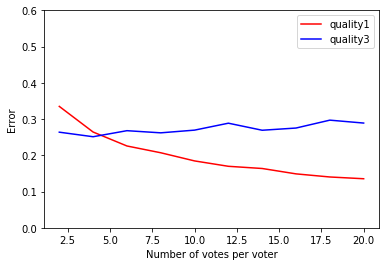

In [56]:
num_votes_error1 = []
num_votes_error3 = []
for i in range(2, 21, 2):
    num_votes_error1.append(get_avg_error(10, n_games=i, mal_prob=0, 
                                          choices_per_game=2, quality_f=quality1))
    num_votes_error3.append(get_avg_error(10, n_games=i, mal_prob=0, 
                                          choices_per_game=2, quality_f=quality3))

    
plt.plot(range(2, 21, 2), num_votes_error1, color='red', label='quality1')
plt.plot(range(2, 21, 2), num_votes_error3, color='blue', label='quality3')
plt.ylim((0, 0.6))
plt.ylabel("Error")
plt.xlabel("Number of votes per voter")
plt.legend(loc='upper right')
plt.show()

### Situation 5

The last situation is different - in this case we introduce the concept of malicious voters. A voter is malicious  who will try to vote for the worst team instead of the best.

**We try to see how the error increases as the proportion of malicious voters increase. The increase is seen quite clearly.**

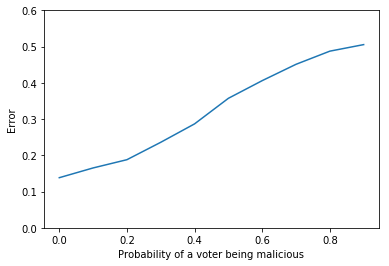

In [51]:
mal_prob_error = []
for i in range(10):
    mal_prob = i/10
    mal_prob_error.append(get_avg_error(10, n_games=20, mal_prob=mal_prob, 
                                         choices_per_game=2, quality_f=quality1))
    
plt.plot([i/10 for i in range(10)], mal_prob_error)
plt.ylim((0, 0.6))
plt.ylabel("Error")
plt.xlabel("Probability of a voter being malicious")
plt.show()

We can potentially design for situations with malicious voters, but analyzing them will take more effort.

A design would likely do the following:
- punish them for voting badly. This can be achieved by detecting the number of times they voted for bad team, which we can identify after the voting ends.
- If voting is voluntary - this may create a disincentive for voting. In that case, we may want to balance that by saying every vote increases their own score.